In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm

In [59]:
df = pd.read_csv('D:\GitHub\MSc-Project\SWaT DataSWaT 2015-12-23.csv')

In [60]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,date,time
0,2015-12-23 00:00:00,0.0,0.994030,0.5,1.0,0.0,0.509983,0.197627,0.500754,0.769136,...,0.0,0.958717,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:00
1,2015-12-23 00:00:01,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.501658,0.863706,...,0.0,0.958466,0.279476,0.962447,0.0,0.0,0.0,0.0,2015-12-23,00:00:01
2,2015-12-23 00:00:02,0.0,0.993523,0.5,1.0,0.0,0.509983,0.197627,0.503767,0.916761,...,0.0,0.957840,0.279476,0.962366,0.0,0.0,0.0,0.0,2015-12-23,00:00:02
3,2015-12-23 00:00:03,0.0,0.993467,0.5,1.0,0.0,0.494624,0.194993,0.506178,0.952045,...,0.0,0.957840,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:03
4,2015-12-23 00:00:04,0.0,0.993072,0.5,1.0,0.0,0.494624,0.194993,0.509593,0.974452,...,0.0,0.958654,0.279476,0.961636,0.0,0.0,0.0,0.0,2015-12-23,00:00:04


In [36]:
def doFourierAnalysis(df, column_name):
    # Extract the data from the DataFrame
    data = df[column_name].values

    # Number of data points
    N = len(data)

    # Compute the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)

    # Compute the Power Spectrum (magnitude of the FFT squared)
    power_spectrum = np.abs(fft_data) ** 2

    # Compute the frequency bins
    # If you have a time step dt between data points, replace 1.0 with dt in the line below
    freq = np.fft.fftfreq(N, 10.0)

    # Plotting the Power Spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freq, power_spectrum)
    plt.title(f'{column_name} Power Spectrum')
    plt.xscale('log')
    plt.xlabel('Frequency')
    plt.yscale('log')
    plt.ylabel('Power')
    plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies
    plt.show()

In [37]:

def performFourierAndLimitHarmonics(df, column_name, num_harmonics):

    data = df[column_name].values

    # Perform the Fast Fourier Transform (FFT)
    fft_data = np.fft.fft(data)
    N = len(data)

    # Compute the magnitude of the FFT and find the indices of the largest components
    magnitudes = np.abs(fft_data)
    indices = np.argsort(magnitudes)[::-1]  # Sort indices by magnitude in descending order

    # Zero out all but the largest `num_harmonics` components
    fft_data_limited = np.zeros(N, dtype=complex)
    for i in range(num_harmonics):
        index = indices[i]
        fft_data_limited[index] = fft_data[index]

    # Inverse FFT to reconstruct the signal with limited harmonics
    reconstructed_signal = np.fft.ifft(fft_data_limited)

    return reconstructed_signal, fft_data_limited




In [118]:
def plot_columns(df, columns_list):

    # Convert the 'time' column to datetime if it's not already in that format
    if df['time'].dtype == object:
        df['time'] = pd.to_datetime(df['time'])

    # Set the size of the plot
    plt.figure(figsize=(12, 6))

    # Loop through the columns and plot each one
    for column in columns_list:
        plt.plot(df['time'], df[column], label=column)

    # Add title and labels
    plt.title('Signals Over Time')
    plt.xlabel('Time')
    plt.yscale('log')
    plt.ylabel('Signal Value')

    # set y range to plot if passed
    plt.ylim( 0.1, 1)

    # Show legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()


In [119]:
def prep_data(df: pd.DataFrame, columns_list: list, start_time: str= None, end_time: str= None) -> pd.DataFrame:
    '''
    :param df: df of scaled results for a single date
    :param columns_list: columns to keep includingtime column
    :param start_time: string in format 'hh:mm:ss', default takes min value in df
    :param end_time: string in format 'hh:mm:ss', default takes max value in df
    :return: df of only values in time windo for specified columns
    '''

    # get times if not passed
    if start_time is None:
        start_time = df['time'].min()
    #else:
    #    start_time = pd.to_datetime(start_time)
    #    print(type(start_time))
    if end_time is None:
        end_time = df['time'].max()
    #else:
    #    end_time = pd.to_datetime(end_time)

    # filter to rows in time window
    df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    df = df[columns_list]
    df_prepped = df.copy()

    # replace low values possibly to tidy graph

    return df_prepped


In [120]:
columns_list = ['time', 'MV101','LIT101','FIT101','P101','FIT201','MV201']

In [152]:
df_prepped = prep_data(df, columns_list, start_time= '00:00:00', end_time= '08:00:00')

In [153]:
columns_to_plot = ['MV101','LIT101','FIT101','P101','FIT201','MV201']

In [154]:
df_prepped.head()
# df.columns

,time,MV101,LIT101,FIT101,P101,FIT201,MV201
0,00:00:00,0.5,0.994030,0.0,1.0,0.769136,1.0
1,00:00:01,0.5,0.993523,0.0,1.0,0.863706,1.0
2,00:00:02,0.5,0.993523,0.0,1.0,0.916761,1.0
3,00:00:03,0.5,0.993467,0.0,1.0,0.952045,1.0
4,00:00:04,0.5,0.993072,0.0,1.0,0.974452,1.0


In [155]:
#df.head()

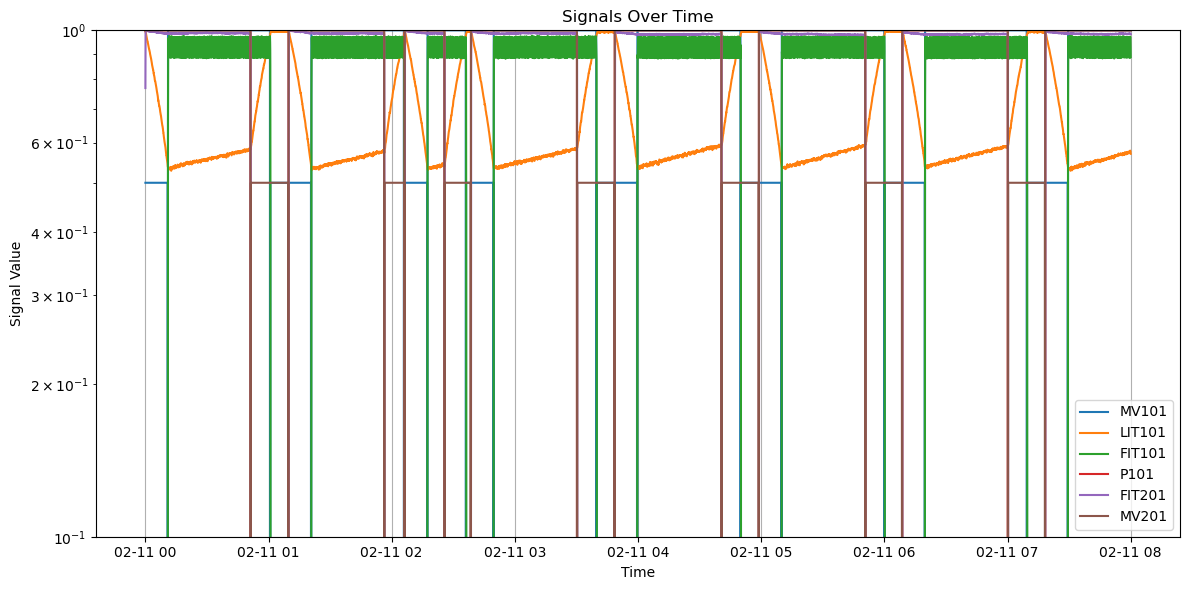

In [156]:
plot_columns(df_prepped, columns_to_plot)

C:\Users\laure\AppData\Local\Temp\ipykernel_18404\2441502937.py:26: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, np.max(freq))  # Limit x-axis to non-negative frequencies


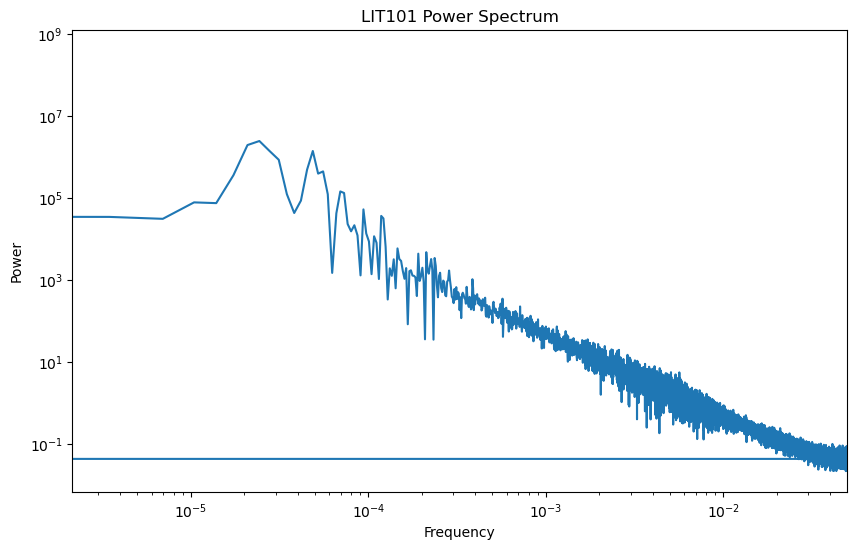

In [157]:
doFourierAnalysis(df_prepped, 'LIT101')

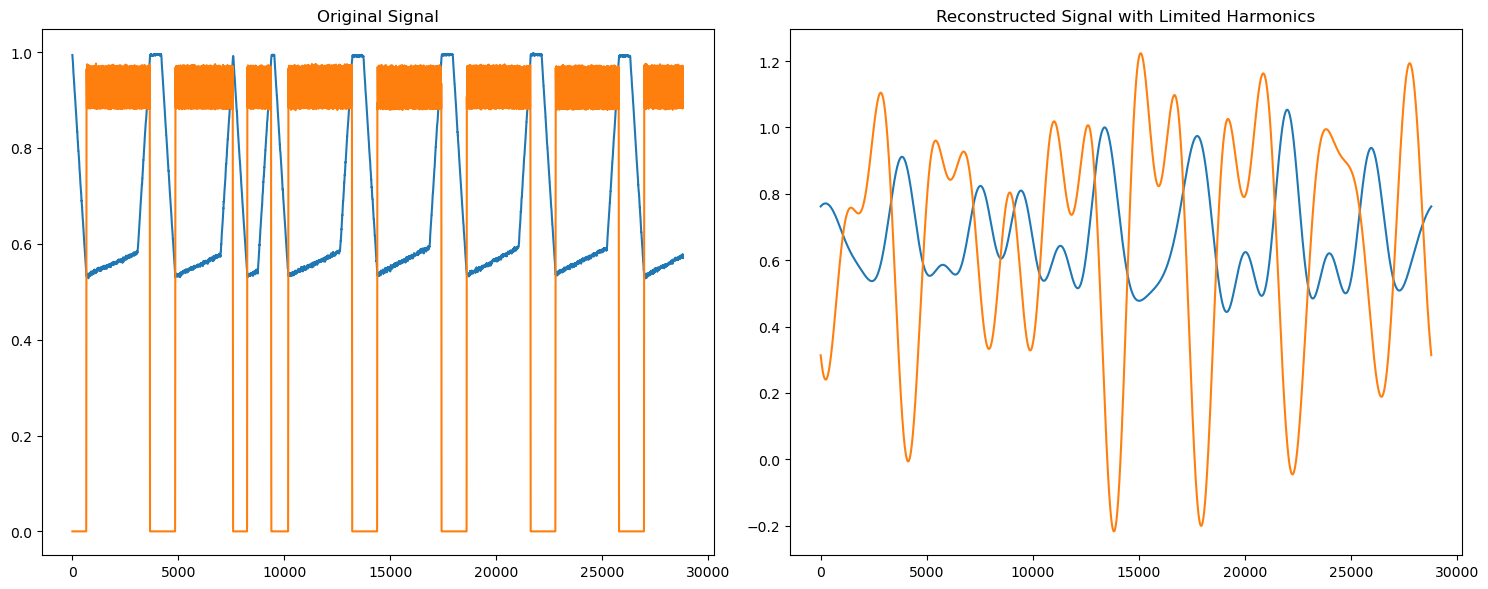

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


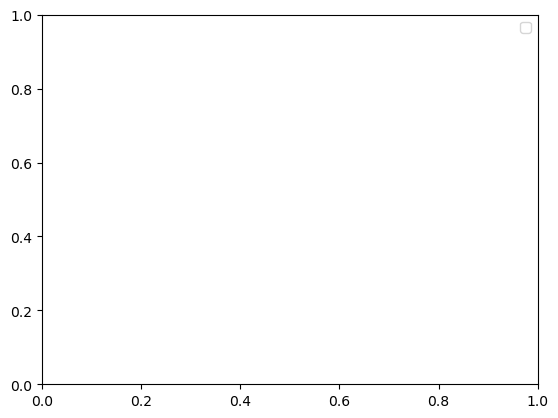

In [159]:
column_name_1 = 'LIT101'
column_name_2 = 'FIT101'
# Example usage:
# signal is your input signal, num_harmonics is the number of harmonics you want to keep
reconstructed_signal_1, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_1, num_harmonics=15)
reconstructed_signal_2, limited_fft_data = performFourierAndLimitHarmonics(df_prepped, column_name_2, num_harmonics=15)
col_1 = df_prepped[column_name_1].values
col_2 = df_prepped[column_name_2].values
# Plot original and reconstructed signals
plt.figure(figsize=(15, 6))

# Original Signal
plt.subplot(1, 2, 1)
plt.plot(col_1, label= column_name_1)
plt.plot(col_2, label= column_name_2)
plt.title('Original Signal')

# Reconstructed Signal with Limited Harmonics
plt.subplot(1, 2, 2)
plt.plot(reconstructed_signal_1.real)  # Take the real part since the output is complex
plt.plot(reconstructed_signal_2.real)  # Take the real part since the output is complex
plt.title('Reconstructed Signal with Limited Harmonics')

plt.tight_layout()
plt.show()
# Show legend
plt.legend()